In [10]:
#!pip3 install neat-python

# from keras.datasets import fashion_mnist
import tensorflow as tf
import numpy as np
import ssl
import neat
from skimage.transform import rescale
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pickle

fashion_mnist = tf.keras.datasets.fashion_mnist



## Global Parameters

In [11]:
# Dataset parameters
STANDARD_IMAGE_SIZE = 28
DESIRED_IMAGE_SIZE = 16
N_CLASSES_TO_USE = 10

RESCALE_FACTOR = DESIRED_IMAGE_SIZE/STANDARD_IMAGE_SIZE
N_PIXELS = DESIRED_IMAGE_SIZE**2

# How many samples to test:
N_SAMPLES_TO_TEST = 200

# Simulation Parameters
NR_GENERATIONS = 1000
CONFIG_FILE = 'NEAT-configs/mnist-wann'

## Load Fashion-MNIST

In [12]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

## Preprocess Fashion-MNIST

### Trim down Dataset

In [13]:
# Ensure correct number of classes
X_train = X_train[Y_train < N_CLASSES_TO_USE]
Y_train = Y_train[Y_train < N_CLASSES_TO_USE]
X_test = X_test[Y_test < N_CLASSES_TO_USE]
Y_test = Y_test[Y_test < N_CLASSES_TO_USE]

# Extract and print the number of training and testing samples remaining
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
print(f"Training samples remaining: {n_samples_train}")
print(f"Testing samples remaining: {n_samples_test}")

Training samples remaining: 60000
Testing samples remaining: 10000


### Rescale Images

In [14]:
# Rescaling to the desired size
def rescale_images(images, do_anti_aliasing=False):
    return np.array([rescale(image, RESCALE_FACTOR, anti_aliasing=do_anti_aliasing) for image in images])

# Rescale X_train and X_test
X_train_small = rescale_images(X_train)
X_test_small = rescale_images(X_test)

### Normalize

In [15]:
# Normalize the data
def normalize(images):
    return (images - np.mean(images, axis=0))/(np.std(images, axis=0) + 0.000001)

# Normalize X_train_small and X_test_small
X_train_norm = normalize(X_train_small)
X_test_norm = normalize(X_test_small)

### Visualize

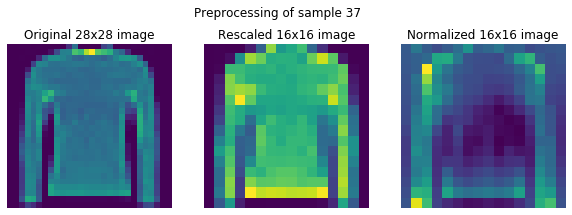

In [16]:
# Plot original and reshaped image
def plot_comparison(idx_to_plot, lists, titles):
    n_plots = len(lists)
    fig, ax = plt.subplots(1,n_plots, figsize=(10,10/n_plots))
    for i in range(n_plots):
        ax[i].imshow(lists[i][idx_to_plot])
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    fig.suptitle(f"Preprocessing of sample {idx_to_plot}",y=1)
    plt.show()
    
plot_comparison(37,
                [X_train, X_train_small, X_train_norm],
                [f"Original {STANDARD_IMAGE_SIZE}x{STANDARD_IMAGE_SIZE} image",
                 f"Rescaled {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image",
                 f"Normalized {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image"])

In [17]:
# Replace and reshape X_train and X_test, for convenience
X_train = X_train_norm.reshape(n_samples_train, DESIRED_IMAGE_SIZE**2)
X_test = X_test_norm.reshape(n_samples_test, DESIRED_IMAGE_SIZE**2)

# NEAT

## Basic Run Function

In [22]:
def exp(x):
    return np.exp(np.clip(x, -float('inf'), 709.))

def sigmoid(output):
    output = [min(709., x) for x in output]
    output = [max(-709., x) for x in output]
    return [1 /(1 + exp(-x)) for x in output]

In [23]:
def step(x):
    return 1.0*(x>0.0)

def cos(x):
    try:
        x = max(-60.0, min(60.0, 5.0 * x))
        return math.cos(x)
    except ValueError:
        print(x)

def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    config.genome_config.add_activation('cos', cos)
    config.genome_config.add_activation('step', step)
    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    
    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(50, filename_prefix='NEAT-checkpoints/neat-checkpoint-10-classes-fashion-'))
    
    
    # Run for up to NR_GENERATIONS generations.
    winner = p.run(eval_genomes, NR_GENERATIONS)
    stats.save_genome_fitness(filename="NEAT-results/fashion_fitness_history.csv")
    
    with open('NEAT-results/best_genomes_fashion', 'wb') as f:
        best_genomes = stats.best_genomes(10)
        pickle.dump(best_genomes,f)
    
    
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))


## Basic Evaluation Function

In [24]:
def eval_genomes(genomes, config):
    
    def _cross_entropy(pred, label):
        return -np.log(exp(pred[label])/np.sum(exp(pred), axis=0))
    
    sample_indices = []
    n_samples_per_class = int(N_SAMPLES_TO_TEST/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= n_samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:n_samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = []
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        
    
    for genome_id, genome in genomes:
        ce = []
        
        genome.fitness = 0.
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        nr_correct = 0.
        for i in sample_indices:
            train, label = X_train[i], Y_train[i]
            output = net.activate(train)
            ce.append(-_cross_entropy(sigmoid(output), label))
#             if np.argmax(sigmoid(output)) == label:
#                 nr_correct += 1.

        genome.fitness = np.average(ce)          
    

In [ ]:
run(CONFIG_FILE)


 ****** Running generation 0 ****** 

Population's average fitness: -2.32546 stdev: 0.02854
Best fitness: -2.25724 - size: (10, 128) - species 1 - id 149
Average adjusted fitness: 0.096
Mean genetic distance 2.351, standard deviation 0.207
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   250     -2.3    0.096     0
Total extinctions: 0
Generation time: 17.829 sec

 ****** Running generation 1 ****** 

Population's average fitness: -2.30822 stdev: 0.02818
Best fitness: -2.23827 - size: (11, 130) - species 1 - id 273
Average adjusted fitness: 0.077
Mean genetic distance 2.358, standard deviation 0.185
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   250     -2.2    0.077     0
Total extinctions: 0
Generation time: 18.007 sec (17.918 average)

 ****** Running generation 2 ****** 

Population's average fitness: -2

## Plot History

In [ ]:
history = np.genfromtxt('NEAT-results/fashion_fitness_history.csv', delimiter='')
best_fitness = history[:,0]
avg_fitness = history[:,1]

In [ ]:
plt.plot(best_fitness, label = 'Best Fitness')
plt.plot(avg_fitness, label = 'Average Fitness')
plt.title('Best and Average Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.legend()
plt.show()

## Load and Test Fittest Member

In [ ]:
def test_fittest(config_file):
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    
    preds_test = []
    preds_train = []
    train_correct = 0.
    test_correct = 0. 
    fittest_genome = pickle.load( open('NEAT-results/best_genomes_fashion', 'rb'))[0]
    #print(fittest_genome)
    net = neat.nn.FeedForwardNetwork.create(fittest_genome, config)
        
    for train, label in zip(X_train, Y_train):
        output = np.argmax(sigmoid(net.activate(train)))
        preds_train.append(output)
        if output == label:
            train_correct += 1.
    train_acc = train_correct / len(X_train)
    
    for test, label in zip(X_test, Y_test):
        output = np.argmax(sigmoid(net.activate(test)))
        preds_test.append(output)
        if output == label:
            test_correct += 1.
    test_acc = test_correct / len(X_test)
        
    print("Train Accuracy = {}".format(train_acc))
    print("Test Accuracy = {}".format(test_acc))
    
    return preds_train, preds_test

In [ ]:
preds_train, preds_test = test_fittest(CONFIG_FILE)

In [ ]:
cm_train = confusion_matrix(Y_train, preds_train, labels=range(N_CLASSES_TO_USE))
cm_test = confusion_matrix(Y_test, preds_test, labels=range(N_CLASSES_TO_USE))

In [ ]:
# Create figure
fig, ax = plt.subplots(1,2, figsize=(11,4))

# Plot confusion matrix for training data
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data')

# Plot confusion matrix for validation data
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for test data')

# Show the result
plt.show()

## Inspecting Fittest Genome

In [ ]:
fittest_genome = pickle.load( open('NEAT-results/best_genomes_fashion', 'rb'))[0]

In [ ]:
print(fittest_genome)

In [ ]:
used_input_pixels = []
for cg in fittest_genome.connections.values():
    if cg.enabled:
        used_input_pixels.append(cg.key[0])
print(used_input_pixels)

In [ ]:
input_tallies = np.zeros(X_train.shape[1])
for arg in used_input_pixels:
    input_tallies[arg] += 1
plt.imshow( input_tallies.reshape(16,16) )
plt.title('Used Input Pixels')
plt.axis('off')
plt.show()